In [2]:
import pickle
import datetime
from dateutil.parser import parse

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np


import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#nltk.download()

In [12]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        #print(top_doc_indices, np.argsort(W[:,topic_idx]))
        for doc_index in top_doc_indices:
            print('document with index',doc_index)
            print(documents[doc_index])
        print(' ')

In [28]:
import matplotlib.pyplot as plt

def plot_topic_trend_lda(H, W, documents, dates):
    plt.figure(figsize=(17,8))
    min_date = min(dates)
    max_date = max(dates)
    min_year, min_week, weekday = min_date.isocalendar()
    max_year, max_week, weekday = max_date.isocalendar()

    plot_data_all = pd.DataFrame(columns=['topic','date','num_docs'])
    
    print('set up dataframe for data', plot_data_all.info())

    #timeframe = 'week'
    timeframe = 'month'
    if timeframe == 'week':
        week_start = min_week
        week_end = (max_year-min_year)*52+max_week + 1

        w = week_end - week_start
        
        for topic in range(len(H)):
            for week in range(week_start,week_end): 
                plot_data_all.at[w*topic+week,'topic'] = topic
                plot_data_all.at[w*topic+week,'date'] = week
        print('weeks in dataframe', week_start, week_end, w)

    elif timeframe == 'month':
        month_start = min_date.month
        max_month = max_date.month
        month_end = (max_year-min_year)*12+max_month + 1
        
        m = month_end - month_start
        
        for topic in range(len(H)):
            for month in range(month_start,month_end): 
                plot_data_all.at[m*topic+month,'topic'] = topic
                plot_data_all.at[m*topic+month,'date'] = month
        print('months in dataframe', month_start, month_end, m)
    
    plot_data_all['num_docs'] = 0
    plot_data_all = plot_data_all.astype('int')    
    
    #print(plot_data_all)
    
    for doc_idx in range(W.shape[0]):
        try:
            topic_idx = W[doc_idx].argmax()

            date_key = dates[doc_idx]
            #print('date_key',doc_idx,date_key)
            if timeframe == 'week':
                year, week, weekday = date_key.isocalendar()

                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    week += 52
                elif year == 2017:
                    week += 104
                elif year == 2018:
                    week += 156
                #print(w*topic_idx+week)
                plot_data_all.loc[w*topic_idx + week,'num_docs'] +=  1
                
            elif timeframe == 'month':
                year = date_key.year
                month = date_key.month
                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    month += 12
                elif year == 2017:
                    month += 24
                elif year == 2018:
                    month += 36
                #print(w*topic_idx+week)
                #print(month, year, topic_idx, m, m*topic_idx + month)

                plot_data_all.loc[m*topic_idx + month,'num_docs'] +=  1
                 
        except:
            topic_idx = W[doc_idx].argmax()
            date_key = dates[doc_idx]
            year, week, weekday = date_key.isocalendar()

            print(year, week,'did not work')
            
    # Normalize the values (percent per time period)
    month_doc_totals = plot_data_all.groupby('date').sum()['num_docs']
    
    for i in range(len(plot_data_all)):
        d = plot_data_all.iloc[i,1]
        if month_doc_totals[d] != 0:
            plot_data_all.iloc[i,2] /= month_doc_totals[d]
    
    for topic in range(len(H)):
        foo = plot_data_all[plot_data_all['topic'] == topic]
        plt.figure()
        plt.plot(foo['date'],foo['num_docs'],label=f'Topic {topic}')
        plt.legend(loc='upper left');
    #return
    return plot_data_all

In [16]:
def plot_topic_trend_ldaKM(groups, predict, dates):
    # groups = number of groups (int)
    # predict = array of group number
    # dates = array of dates that matches predict
    plt.figure(figsize=(17,8))
    min_date = min(dates)
    max_date = max(dates)
    min_year, min_week, weekday = min_date.isocalendar()
    max_year, max_week, weekday = max_date.isocalendar()

    plot_data_all = pd.DataFrame(columns=['topic','date','num_docs'])
    
    #timeframe = 'week'
    timeframe = 'month'
    if timeframe == 'week':
        week_start = min_week
        week_end = (max_year-min_year)*52+max_week + 1

        w = week_end - week_start
        
        for topic in range(groups):
            for week in range(week_start,week_end): 
                plot_data_all.at[w*topic+week,'topic'] = topic
                plot_data_all.at[w*topic+week,'date'] = week
        print('weeks in dataframe', week_start, week_end, w)

    
    elif timeframe == 'month':
        month_start = min_date.month
        max_month = max_date.month
        month_end = (max_year-min_year)*12+max_month + 1
        
        m = month_end - month_start
        
        for topic in range(groups):
            for month in range(month_start,month_end): 
                plot_data_all.at[m*topic+month,'topic'] = topic
                plot_data_all.at[m*topic+month,'date'] = month
        print('months in dataframe', month_start, month_end, m)
    
    plot_data_all['num_docs'] = 0
    plot_data_all = plot_data_all.astype('int')    
    print('set up dataframe for data',plot_data_all.info())

    #print(plot_data_all)
    
    for doc_idx in range(predict.shape[0]):
        try:
            topic_idx = predict[doc_idx]

            date_key = dates[doc_idx]
            if timeframe == 'week':
                year, week, weekday = date_key.isocalendar()

                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    week += 52
                elif year == 2017:
                    week += 104
                elif year == 2018:
                    week += 156
                #print(w*topic_idx+week)
                plot_data_all.loc[w*topic_idx + week,'num_docs'] +=  1
                
            elif timeframe == 'month':
                year = date_key.year
                month = date_key.month
                #print('month, year', month, year)
                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    month += 12
                elif year == 2017:
                    month += 24
                elif year == 2018:
                    month += 36
                #print(w*topic_idx+week)
                #print(month, year, topic_idx, m, m*topic_idx + month)

                plot_data_all.loc[m*topic_idx + month,'num_docs'] +=  1

        except:
            topic_idx = predict[doc_idx]
            date_key = dates[doc_idx]
            year, week, weekday = date_key.isocalendar()
            month = date_key.month
            #print(year, month,topic_idx, m*topic_idx + month,'did not work')
        
    # Normalize the values (percent per time period)
    month_doc_totals = plot_data_all.groupby('date').sum()['num_docs']
    
    for i in range(len(plot_data_all)):
        d = plot_data_all.iloc[i,1]
        if month_doc_totals[d] != 0:
            plot_data_all.iloc[i,2] /= month_doc_totals[d]

    for topic in range(groups):
        foo = plot_data_all[plot_data_all['topic'] == topic]
        plt.figure()
        plt.plot(foo['date'],foo['num_docs'],label=f'Topic {topic}')
        plt.legend(loc='upper left');
        
    return
#    return plot_data_all



In [6]:
with open ('all_data_desk.pkl', 'rb') as fp:
    df = pickle.load(fp)


In [7]:
# there's some bad data in the snippets.  Drop the rows that have NaN to clean this up
df.dropna(inplace=True)
#df.dropna(subset=['headline'],inplace=True)
#df.dropna(subset=['snippet'],inplace=True)

# choose which news desks to include
news_desk_use = ['National','Foreign','Politics','U.S.','Washington','U.S. / Politics','World / Europe',
                 'World / Middle East','World / Asia Pacific','U.S. / Election 2016','World Americas','NewsDesk']
df2 = pd.DataFrame()
for desk in news_desk_use:
    topic = df['news_desk'] == desk
    df2 = pd.concat([df2,df[topic]])
    
#df2 = df2.sample(200)
# create an new dataframe that combines the headline and snippet (more words in document)

#df2 = df.copy()

df2['head_snip'] = df2['headline'] + ' '+ df2['snippet']

dates = list(df2['date'].copy())

documents = list(df2['head_snip'].copy())

df2.shape


(47256, 5)

In [9]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
#tf = tf_vectorizer.fit_transform(documents)
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [8]:
with open('lda_model.pkl', 'rb') as fp:
    lda_model = pickle.load(fp)


In [26]:
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_


In [27]:
lda_W.shape


(47256, 20)

In [ ]:
no_top_words = 10
no_top_documents = 5
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
topic       0 non-null object
date        0 non-null object
num_docs    0 non-null object
dtypes: object(3)
memory usage: 0.0+ bytes
set up dataframe for data None
months in dataframe 1 48 47


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1224x576 with 0 Axes>

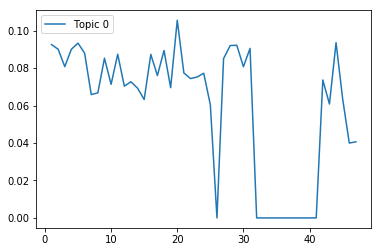

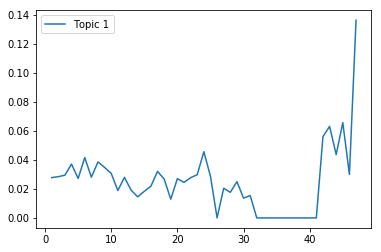

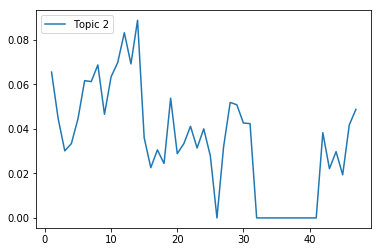

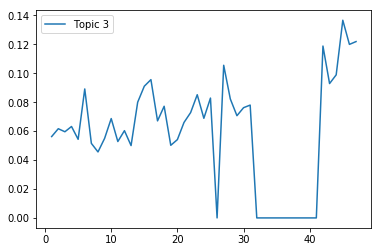

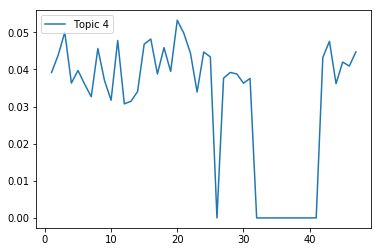

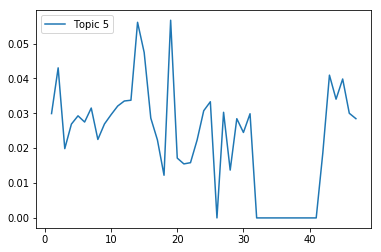

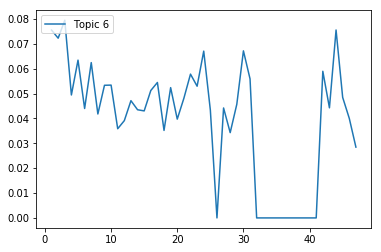

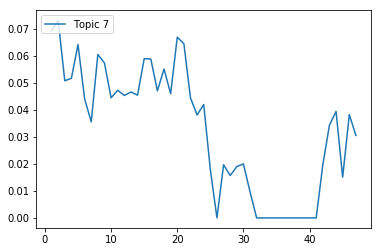

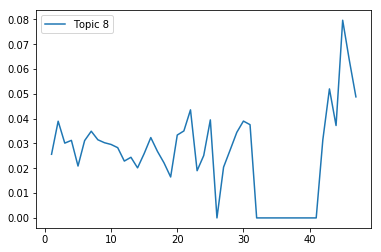

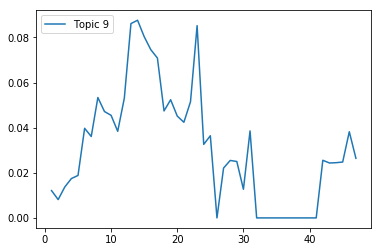

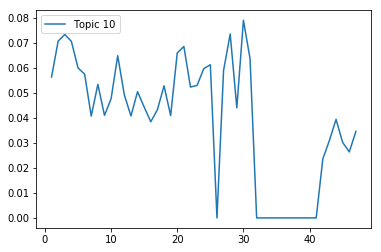

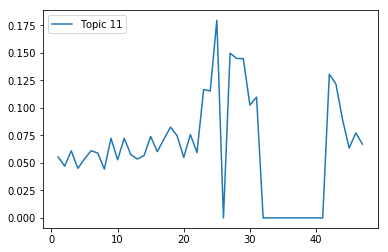

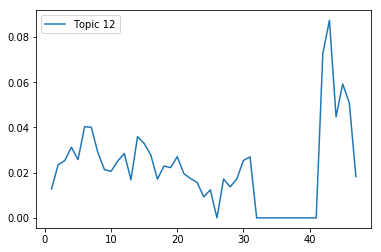

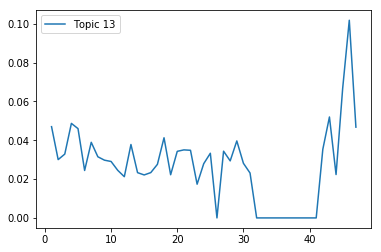

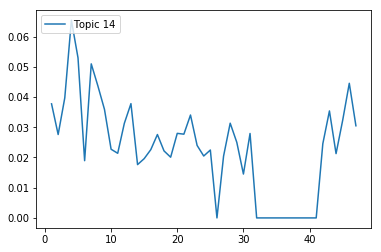

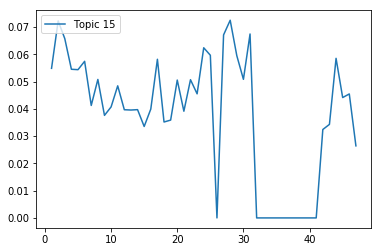

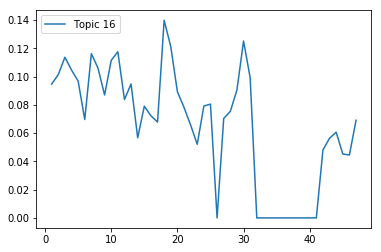

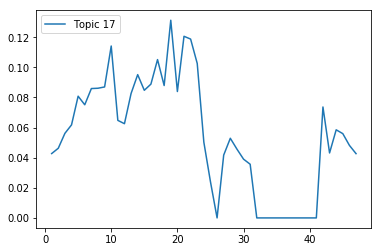

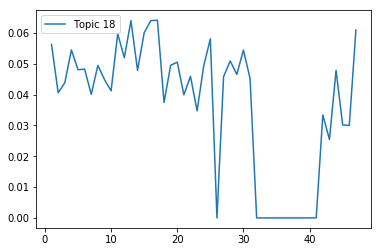

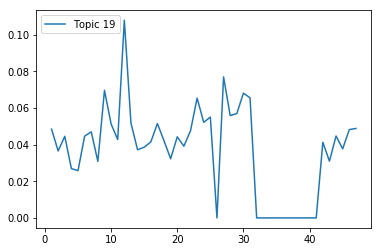

In [29]:
foo = plot_topic_trend_lda(lda_H, lda_W, documents, dates)


In [30]:
foo.to_csv('plot_data_all_20.csv')

In [19]:
import pyLDAvis.gensim
import pyLDAvis.sklearn

import gensim
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.179047  0.108242       1        1  8.226255
11     0.113998  0.127526       2        1  7.645781
3      0.156789 -0.125112       3        1  7.022950
17     0.162023 -0.139900       4        1  6.887546
16     0.015556  0.251640       5        1  6.731845
15     0.117396  0.097114       6        1  5.852794
6      0.076464  0.007144       7        1  5.621511
19     0.089727 -0.126124       8        1  5.303077
2      0.088144 -0.138994       9        1  5.216493
10     0.022024  0.094196      10        1  5.180466
18    -0.006614  0.000958      11        1  4.724394
9     -0.153146 -0.038481      12        1  3.889445
4     -0.090724  0.069141      13        1  3.809843
5     -0.031588 -0.100660      14        1  3.792042
7     -0.111000 -0.009019      15        1  3.777738
14    -0.105997  0.003493      16        1  3.449960
8     -0.107226 -0.016017      17        1  3.372749
13    -0.139950 -0.001406      18        1  3.354987
1     -0.113829 -0.034062      19        1  3.225427
12    -0.161094 -0.029680      20        1  2.914698, topic_info=       Category         Freq               Term        Total  loglift  logprob
term                                                                          
148606  Default  9272.000000              trump  9272.000000  30.0000  30.0000
109928  Default  6688.000000          president  6688.000000  29.0000  29.0000
44166   Default  3233.000000             donald  3233.000000  28.0000  28.0000
44172   Default  3185.000000       donald trump  3185.000000  27.0000  27.0000
28766   Default  3233.000000            clinton  3233.000000  26.0000  26.0000
107088  Default  2822.000000             police  2822.000000  25.0000  25.0000
152402  Default  1903.000000             united  1903.000000  24.0000  24.0000
137768  Default  1881.000000             states  1881.000000  23.0000  23.0000
64763   Default  2202.000000            hillary  2202.000000  22.0000  22.0000
34502   Default  2320.000000              court  2320.000000  21.0000  21.0000
92048   Default  3590.000000                 mr  3590.000000  20.0000  20.0000
97833   Default  2427.000000              obama  2427.000000  19.0000  19.0000
135030  Default  1403.000000              south  1403.000000  18.0000  18.0000
76331   Default  2048.000000             killed  2048.000000  17.0000  17.0000
104386  Default  2719.000000             people  2719.000000  16.0000  16.0000
95253   Default  4955.000000                new  4955.000000  15.0000  15.0000
64764   Default  1771.000000    hillary clinton  1771.000000  14.0000  14.0000
26377   Default  2360.000000              china  2360.000000  13.0000  13.0000
156892  Default  1474.000000                war  1474.000000  12.0000  12.0000
89827   Default  1527.000000           minister  1527.000000  11.0000  11.0000
152485  Default  1329.000000      united states  1329.000000  10.0000  10.0000
71315   Default  1259.000000               iran  1259.000000   9.0000   9.0000
66406   Default  2144.000000              house  2144.000000   8.0000   8.0000
21684   Default  2131.000000           campaign  2131.000000   7.0000   7.0000
38605   Default  1405.000000             debate  1405.000000   6.0000   6.0000
70452   Default  1546.000000      international  1546.000000   5.0000   5.0000
34018   Default  1700.000000            country  1700.000000   4.0000   4.0000
8454    Default  1867.000000           american  1867.000000   3.0000   3.0000
119802  Default  2231.000000         republican  2231.000000   2.0000   2.0000
158890  Default  1279.000000              white  1279.000000   1.0000   1.0000
...         ...          ...                ...          ...      ...      ...
135055  Topic20   333.019324     south carolina   333.865861   3.5329  -4.8806
135631  Topic20   287.466567            special   288.313103   3.5325  -5.0277
135168  Topic20   165.7220

In [20]:
c = 15
km = KMeans(n_clusters=c,random_state=10,n_init=1)
km.fit(lda_W)
predict = km.predict(lda_W)

In [93]:
for p in range(len(predict)):
    if predict[p] == 0:
        print(documents[p])
        print('')


Supreme Court, in Big Leap, Plans to Put Filings Online Chief Justice John G. Roberts Jr. said the changes would come &#8220;as soon as 2016&#8221; in his annual year-end report on the condition of the federal judiciary....

Heavyweight Response to Local Fracking Bans The oil and gas industry has responded aggressively to a wave of local, citizen-led bans on hydraulic fracturing, arguing in court that only state officials can impose such rules....

Republicans Say They’ll Act Fast to Push Agenda Eager to show that they can govern well as they take control of Congress, Republicans aim to quickly advance energy and health care legislation....

Colorado: Explosive Set Off Near N.A.A.C.P. Building  The authorities are looking for a man who may have information about an explosion set off near the Colorado Springs chapter of the N.A.A.C.P....

Obama to Outline Proposals to Bolster a Lagging Housing Sector President Obama will seek to address the disappointing housing sector Thursday, lowerin

ISIS Is Winning the Social Media War, U.S. Concludes An internal State Department assessment says the Islamic State&#8217;s social message machine is trumping efforts by the Obama administration and its foreign allies to combat it....

Success of Kurdish Forces Is a Rare Bright Spot for U.S. Policy in Iraq The ability of pesh merga forces to retake and defend territory has offered a glimmer of hope for the Obama administration&#8217;s policy of coordinating with local forces to battle the Islamic State....

Germany Drops Inquiry Into Claims U.S. Tapped Angela Merkel’s Phone The investigation over allegations of eavesdropping by the N.S.A. was ended because of a lack of concrete evidence, a federal prosecutor said....

Wave of Protests Spreads to Scandal-Weary Honduras and Guatemala Middle-class citizens in both countries are fed up with bribery and other government scandals and increasingly demanding the resignation of their presidents....

Israeli Helped Inspire U.S.-Russia Weapons De

1917: Plot to Kill the President Is Discovered A 31-year-old German is reported to have confessed to playing a role in a plot to assassinate President Wilson....

Iraqi Forces Enter Western Mosul, in Fierce Battle Against ISIS The chief of the federal police said that soldiers had retaken a government compound, a branch of the central bank and an archaeological museum....

ISIS Appears to Lose Ground in Fight for Its Raqqa Base American-backed militia fighters in Syria said they helped to isolate Raqqa, the Islamic State’s de facto capital, by capturing an important supply route....

ISIS Leaders Are Fleeing Raqqa, U.S. Military Says Some of the Islamic State’s leaders have fled as Syrian fighters backed by the United States close in on the group’s self-declared capital, but many militants remain....

Danish Father and Son Team Up on Homework and Turn In a German Warplane A homework assignment on World War II, and a father’s jokey suggestion, led to the discovery of a fighter plane tho

In [104]:
# print articles closest to centroid from K-Means

from sklearn.metrics.pairwise import euclidean_distances

centers = np.array(km.cluster_centers_)

mat = lda_W

for i in range(c):
    print(f'K Means Cluster {i}')
    cent = centers[i].reshape(20,-1)
    cent = cent.T
    #print(cent)
    
    dist = euclidean_distances(cent, mat)
    min_dist = min(dist[0][1:])
    print('min euclidean distance = ',min_dist)
    
    for pt in range(len(predict)):
        if predict[pt] == i:
            if dist[0][pt] < 1.2* min_dist:
                print('**',documents[pt])
    print(" ")


K Means Cluster 0
min euclidean distance =  0.11307410576551631
** Thousands Enter Syria to Join ISIS Despite Global Efforts Nearly 30,000 foreign recruits have now poured into Syria to join the civil war, stark evidence that an international effort to enforce antiterrorism laws is not diminishing the militants’ ranks....
** Malaysian Security Law Invites Government Abuses, Rights Groups Say The bill passed Thursday by Parliament, including changes to police privileges, comes after growing complaints about assaults on civil liberties....
** Israel Frees Palestinian Girl, 12, Who Tried to Stab Guard Dima al-Wawi, the youngest known Palestinian inmate, was released weeks early and greeted with a hero’s welcome in her West Bank hometown....
** ISIS Seems to Tailor Attacks for Different Audiences In Europe and the West, Islamic State operatives have been instructed to kill at random, but more care is seemingly taken in planning attacks in majority Sunni Muslim nations like Bangladesh....
*

** Ukraine Ban on Russian Symbols Fuels Fight Over National Identity Older Ukrainians seeking to preserve the past resist a law pushed through Parliament that requires the removal of all Communist-era names and symbols....
** Israel: Campaign Aims to Attract Russian Tourists The campaign was prompted in part by the recent bombing of a Russian airliner in Egypt and the downing of a Russian warplane by Turkey....
** World Leaders Agree to Extend Efforts to End Ukraine Conflict The leaders of Russia, Ukraine, France and Germany called for the Minsk peace agreement to be carried out in full in 2016....
** U.S. to Send Military Advisers Closer to Front Lines of ISIS Fight in Iraq The move, announced by Defense Secretary Ashton B. Carter, puts the Americans closer to the Iraqi soldiers involved in combat, allowing for timely guidance....
** Abu Sayyaf Militants Thriving as Hostage-Takers in Philippines Crime, endemic corruption and poverty are fueling continued kidnappings by the Islamist fi

** U.S. Prepares to House Up to 20,000 Migrants on Military Bases The Pentagon has been assessing whether bases can be used to house both families and children detained at the border, as President Trump criticized what he called “extremist, open-border Democrats.”
** Trump to Skip Meetings in Asia as He Keeps a Distance With Allies In his decision not to attend summit meetings in Asia this fall, the president will miss an opportunity to calm frazzled relationships in the region. And China could step in, analysts said.
** They’re Trained for War. Now American Troops Are Headed to the U.S. Border President Trump’s pledge to send soldiers to the border likely will be costly, will divert military resources from other conflicts and threats and has echoes of a 2014 scare over Ebola.
** Trump Officials on Russian Meddling Threat: Democracy ‘Is in the Cross Hairs’ The heads of the national security agencies said that Russia was attempting to influence the midterm elections. Their remarks were 

** Stakes Rise in Standoff Between Catalan Separatists and Spanish Government Catalonia’s main separatist parties on Tuesday announced a new push for independence. The plan was swiftly denounced by Spain’s prime minister, Mariano Rajoy....
** Netanyahu’s Dog Sinks Teeth Into Guests Kaiya, the Netanyahu family dog, had to be quarantined under Israeli law this week for biting two guests at the prime minister’s Hanukkah party....
** Debate Accusation Inserts Drama Into Spanish Election The Socialist leader, Pedro S&#225;nchez, attacked Prime Minister Mariano Rajoy over allegations of high-level corruption and accused him of lying over his government&#8217;s economic record....
** Hungary’s Migrant Stance, Once Denounced, Gains Some Acceptance While repelled by the hate-mongering that has accompanied Prime Minister Viktor Orban’s positions, European leaders have begun to echo him on many points....
** ‘We Live in a Society Where the Word “Liberal” Is Considered an Insult’ Saudis and others

"    \n    closest_to_center = np.argmax(dist)\n    print(f'Document {closest_to_center}:  ',documents[closest_to_center])\n    dist = np.delete(dist, closest_to_center,)\n    \n    closest_to_center = np.argmax(dist)\n    print(f'Document {closest_to_center}:  ',documents[closest_to_center])\n    dist = np.delete(dist, closest_to_center,)\n    \n    closest_to_center = np.argmax(dist)\n    print(f'Document {closest_to_center}:  ',documents[closest_to_center])\n    dist = np.delete(dist, closest_to_center,)\n    \n    closest_to_center = np.argmax(dist)\n    print(f'Document {closest_to_center}:  ',documents[closest_to_center])\n    dist = np.delete(dist, closest_to_center,)\n\n    closest_to_center = np.argmax(dist)\n    print(f'Document {closest_to_center}:  ',documents[closest_to_center])\n    dist = np.delete(dist, closest_to_center,)\n    print(' ')\n"

In [ ]:
df_centers =

In [97]:
type(centers)

numpy.ndarray